# MAST30034 Applied Data Science Project 1 Preprocessing

Student Name: Haonan Zhong

Student ID: 867492

In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calander
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

# Data Importing

In [2]:
# read datasets
yellow_01 = pd.read_csv('../raw_data/yellow_2018_01.csv')
yellow_02 = pd.read_csv('../raw_data/yellow_2018_02.csv')
yellow_07 = pd.read_csv('../raw_data/yellow_2018_07.csv')
yellow_08 = pd.read_csv('../raw_data/yellow_2018_08.csv')

# combine the monthly data as a season
winter = pd.concat([yellow_01, yellow_02]).reset_index(drop=True)
summer = pd.concat([yellow_07, yellow_08]).reset_index(drop=True)

In [3]:
# labeling dataset as winter and summer

winter['season'] = 'winter'
summer['season'] = 'summer'
# remove any invalid date
winter = winter[(winter['tpep_pickup_datetime'] >= '2018-01-01 00:00:00') 
    & (winter['tpep_pickup_datetime'] <= '2018-02-28 23:59:59') 
    & (winter['tpep_dropoff_datetime'] >= '2018-01-01 00:00:00') 
    & (winter['tpep_dropoff_datetime'] <= '2018-02-28 23:59:59')]
summer = summer[(summer['tpep_pickup_datetime'] >= '2018-07-01 00:00:00') 
    & (summer['tpep_pickup_datetime'] <= '2018-08-31 23:59:59') 
    & (summer['tpep_dropoff_datetime'] >= '2018-07-01 00:00:00') 
    & (summer['tpep_dropoff_datetime'] <= '2018-08-31 23:59:59')]
data = pd.concat([winter, summer]).reset_index(drop=True)

# Feature Engineering

In [4]:
# extract day and time, the calculate the duration of the trip
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
data['date'] = data['tpep_pickup_datetime'].dt.normalize()
data['time'] = data['tpep_pickup_datetime'].dt.hour
data['weekday'] = data['date'].dt.day_name()
data['duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']
data['duration'] = data['duration'] / np.timedelta64(1, 'm')

In [5]:
# identifying holidays
cal = calander()
holidays = cal.holidays(start='2018-01-01', end='2018-12-31')
data['holiday'] = data['date'].isin(holidays)
data['week'] = data['date'].dt.dayofweek
data.loc[data['week'] >= 5, 'day_type'] = "weekend"
data.loc[data['week'] < 5, 'day_type'] = "workday"
data.loc[data['holiday'] == True, 'day_type'] = "holiday"
data = data.drop(['holiday', 'week'], axis=1)

In [6]:
# calculate tip percentage using tip amount and total amount
data['tip_percent'] = (data.tip_amount / data.total_amount) * 100

In [7]:
# classify a trip's time slot

def time_slots(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,17):
        return 'Afternoon'
    elif x in range(17,22):
        return 'Evening'
    else:
        return 'Late Night'

data['time_desc'] = data['time'].apply(time_slots)

In [8]:
# drop features that we are not interested in
data = data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge'], axis=1)

In [9]:
# descriptive statistics for continuous attributes
data[['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'duration', 'tip_percent']].describe()

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount,duration,tip_percent
count,3.294445e+07,3.294445e+07,3.294445e+07,3.294445e+07,3.294445e+07,3.294445e+07,3.294445e+07,3.294010e+07
mean,1.602748e+00,2.895359e+00,1.272862e+01,1.822526e+00,3.285116e-01,1.601285e+01,1.646744e+01,1.063089e+01
std,1.249990e+00,3.332464e+01,2.305309e+02,2.541376e+00,1.752373e+00,2.306810e+02,6.401230e+01,8.429913e+00
min,0.000000e+00,0.000000e+00,-4.980000e+02,-3.224200e+02,-2.150000e+01,-4.988000e+02,-1.294262e+04,-3.333333e+01
25%,1.000000e+00,9.500000e-01,6.500000e+00,0.000000e+00,0.000000e+00,8.300000e+00,6.400000e+00,0.000000e+00
50%,1.000000e+00,1.600000e+00,9.000000e+00,1.360000e+00,0.000000e+00,1.175000e+01,1.070000e+01,1.470588e+01
75%,2.000000e+00,2.990000e+00,1.400000e+01,2.360000e+00,0.000000e+00,1.725000e+01,1.748333e+01,1.666667e+01
max,1.920000e+02,1.894838e+05,9.070702e+05,4.960000e+02,1.049990e+03,9.070710e+05,8.977183e+03,1.000000e+02


<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

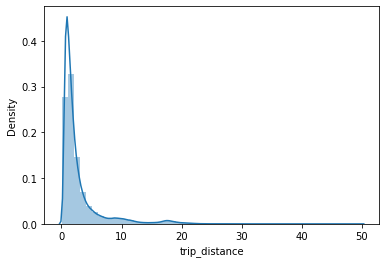

In [10]:
sns.distplot(data[(data['trip_distance'] > 0) & (data['trip_distance'] <= 50)]['trip_distance'])

<AxesSubplot:xlabel='duration', ylabel='Density'>

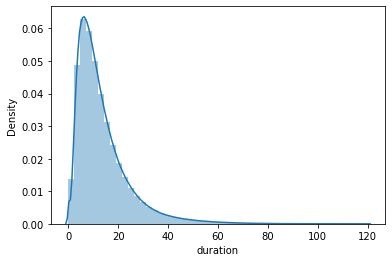

In [11]:
sns.distplot(data[(data['duration'] > 0) & (data['duration'] < 120)]['duration'])

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

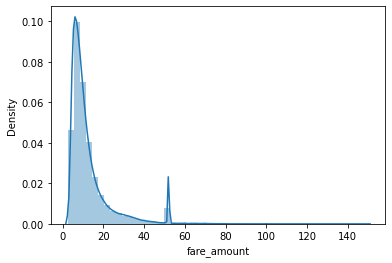

In [12]:
sns.distplot(data[(data['fare_amount'] >= 2.5)&(data['fare_amount'] <= 150)]['fare_amount'])

<AxesSubplot:xlabel='tip_amount', ylabel='Density'>

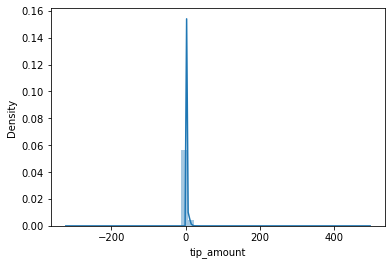

In [13]:
sns.distplot(data.tip_amount)

In [14]:
# remove invalid data
# passenger == 0
data = data[(data['passenger_count'] > 0) & (data['passenger_count'] < 7)]

# trip_distance <= 0
data = data[(data['trip_distance'] > 0) & (data['trip_distance'] <= 100)]

# exclude duration longer than 180 mins
data = data[(data['duration'] > 0) & (data['duration'] <= 180)]

# payment method other than cash and credit card
data = data[(data['payment_type'] != 3) & (data['payment_type'] != 4) & (data['payment_type'] != 5) & (data['payment_type'] != 6)]

# exclude instances with fare amount less than 2.5
data = data[(data['fare_amount'] >= 2.5) & (data['fare_amount'] <= 250)]

# remove trips with tip precentage over 50%
data = data[(data['tip_percent'] >= 0) & (data['tip_percent'] <= 50)]

# PU and DO location id not within NYC taxi zone
data = data[(data['PULocationID'] >= 1) & (data['PULocationID'] <= 263) & (data['DOLocationID'] >= 1) & (data['DOLocationID'] <= 263)]

In [15]:
# convert passenger amount into three level
def passenger_convert(row):
    if (row >= 1) & (row <= 2):
        val = "small"
    elif (row > 2) & (row < 5):
        val = "medium"
    else:
        val = "high"
    return val

data['passenger_count'] = data['passenger_count'].apply(passenger_convert)

In [16]:
data['passenger_count'].value_counts()

small     27337158
high       2378549
medium     1964332
Name: passenger_count, dtype: int64

# Preprocess external weather dataset

In [17]:
weather = pd.read_csv('../raw_data/weather_2018.csv')
weather['TAVG'] = (weather['TMAX'] + weather['TMIN']) / 2
weather = weather.drop(['STATION', 'NAME', 'WT01', 'WT02', 'WT03', 'WT04', 'WT06', 'WT08', 'TMAX', 'TMIN'], axis=1)
weather['DATE'] = pd.to_datetime(weather['DATE'])

In [18]:
# merge weather dataset and taxi dataset
data = pd.DataFrame(pd.merge(data, weather, left_on='date', right_on='DATE')).drop('DATE', axis=1)

In [22]:
# Identify pickup and dropoff borough
zone_df = pd.read_csv('../raw_data/taxi_zone_lookup.csv')
data = pd.DataFrame(pd.merge(data, zone_df[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)
data = data.rename({'Borough':'PUborough'}, axis=1)
data = pd.DataFrame(pd.merge(data, zone_df[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)
data = data.rename({'Borough':'DOborough'}, axis=1)

In [20]:
# Identify pick up and dropoff location thats from airport

data.loc[data['PULocationID'] == 132, 'PUborough'] = 'JFK'
data.loc[data['DOLocationID'] == 132, 'DOborough'] = 'JFK'
data.loc[data['PULocationID'] == 138, 'PUborough'] = 'LaGuardia'
data.loc[data['DOLocationID'] == 138, 'DOborough'] = 'LaGuardia'

In [21]:
# save to feather
data.to_feather('../preprocessed_data/cleaned_2018.feather')